<a href="https://colab.research.google.com/github/nihal-rao/Integrated-Real-time-2D-hand-pose/blob/master/Training_NZSL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Install detectron2

In [ ]:
!nvidia-smi

Wed Jul  1 12:35:11 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.36.06    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   44C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
!pip install -U torch==1.4+cu100 torchvision==0.5+cu100 -f https://download.pytorch.org/whl/torch_stable.html 
!pip install cython pyyaml==5.1
!pip install -U 'git+https://github.com/cocodataset/cocoapi.git#subdirectory=PythonAPI'
import torch, torchvision
torch.__version__
!gcc --version

In [ ]:
!pip install detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu100/torch1.4/detectron2-0.1.1%2Bcu100-cp36-cp36m-linux_x86_64.whl

In [ ]:
import shutil
shutil.copyfile("/content/drive/My Drive/KP_RN_Configs/fpn_keypoint.py","/usr/local/lib/python3.6/dist-packages/detectron2/modeling/backbone/fpn_keypoint.py" )
shutil.copyfile("/content/drive/My Drive/KP_RN_Configs/retinanet_keypoint_only.py","/usr/local/lib/python3.6/dist-packages/detectron2/modeling/meta_arch/retinanet_keypoint.py")
shutil.copyfile("/content/drive/My Drive/KP_RN_Configs/roi_head_mod_final.py","/usr/local/lib/python3.6/dist-packages/detectron2/modeling/roi_heads/roi_head_mod.py")
shutil.copyfile("/content/drive/My Drive/KP_RN_Configs/roi_head_init.py","/usr/local/lib/python3.6/dist-packages/detectron2/modeling/roi_heads/__init__.py")
shutil.copyfile("/content/drive/My Drive/KP_RN_Configs/backbone_init.py","/usr/local/lib/python3.6/dist-packages/detectron2/modeling/backbone/__init__.py")
shutil.copyfile("/content/drive/My Drive/KP_RN_Configs/meta_arch_init.py","/usr/local/lib/python3.6/dist-packages/detectron2/modeling/meta_arch/__init__.py")
shutil.copyfile("/content/drive/My Drive/KP_RN_Configs/train_loop.py","/usr/local/lib/python3.6/dist-packages/detectron2/engine/train_loop.py")
shutil.copyfile("/content/drive/My Drive/KP_RN_Configs/det_checkpoint.py","/usr/local/lib/python3.6/dist-packages/detectron2/checkpoint/detection_checkpoint.py")
shutil.copyfile("/content/drive/My Drive/KP_RN_Configs/build.py","/usr/local/lib/python3.6/dist-packages/detectron2/modeling/meta_arch/build.py")
shutil.copyfile("/content/drive/My Drive/KP_RN_Configs/keypoint_head_xy.py","/usr/local/lib/python3.6/dist-packages/detectron2/modeling/roi_heads/keypoint_head.py")

'/usr/local/lib/python3.6/dist-packages/detectron2/modeling/roi_heads/keypoint_head.py'

In [ ]:
import numpy as np
import os
import cv2
import random
from google.colab.patches import cv2_imshow
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()
from detectron2 import model_zoo
from detectron2.engine import DefaultTrainer, DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog


##Loading data

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive/


In [ ]:
from detectron2.data.datasets import register_coco_instances
import os
import numpy as np
import json
from detectron2.structures import BoxMode
from detectron2.data import DatasetCatalog, MetadataCatalog

register_coco_instances("nzsl_train", {}, "/content/drive/My Drive/NZSL/hands_keypoints_train.json", "/content/drive/My Drive/NZSL/train_imgs")
register_coco_instances("nzsl_test", {}, "/content/drive/My Drive/NZSL/hands_keypoints_test.json", "/content/drive/My Drive/NZSL/test_imgs")

train_metadata = MetadataCatalog.get("nzsl_train")
val_metadata = MetadataCatalog.get("nzsl_test")

[06/20 08:43:36 d2.data.datasets.coco]: Loaded 515 images in COCO format from /content/drive/My Drive/NZSL/hands_keypoints_train.json


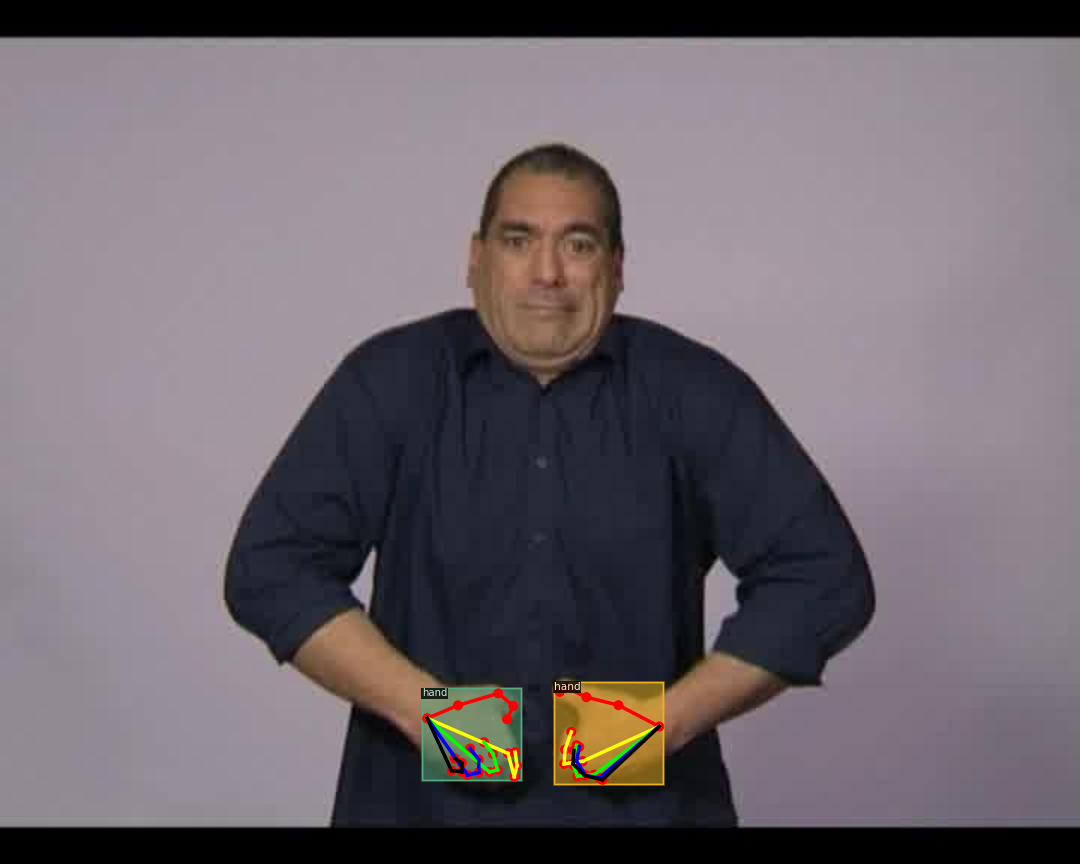

/content/drive/My Drive/NZSL/train_imgs/Ricki_unit_8.flv_000082_.jpg


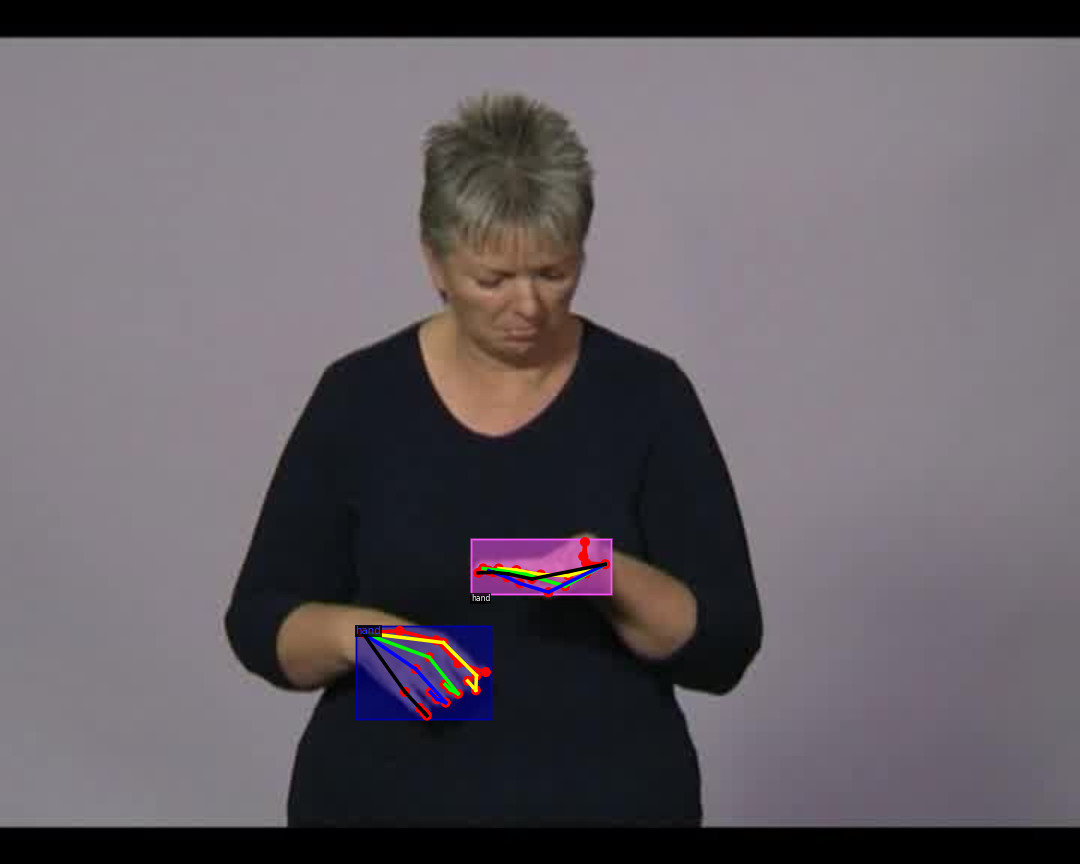

/content/drive/My Drive/NZSL/train_imgs/Jackie_unit_10.flv_000137_.jpg


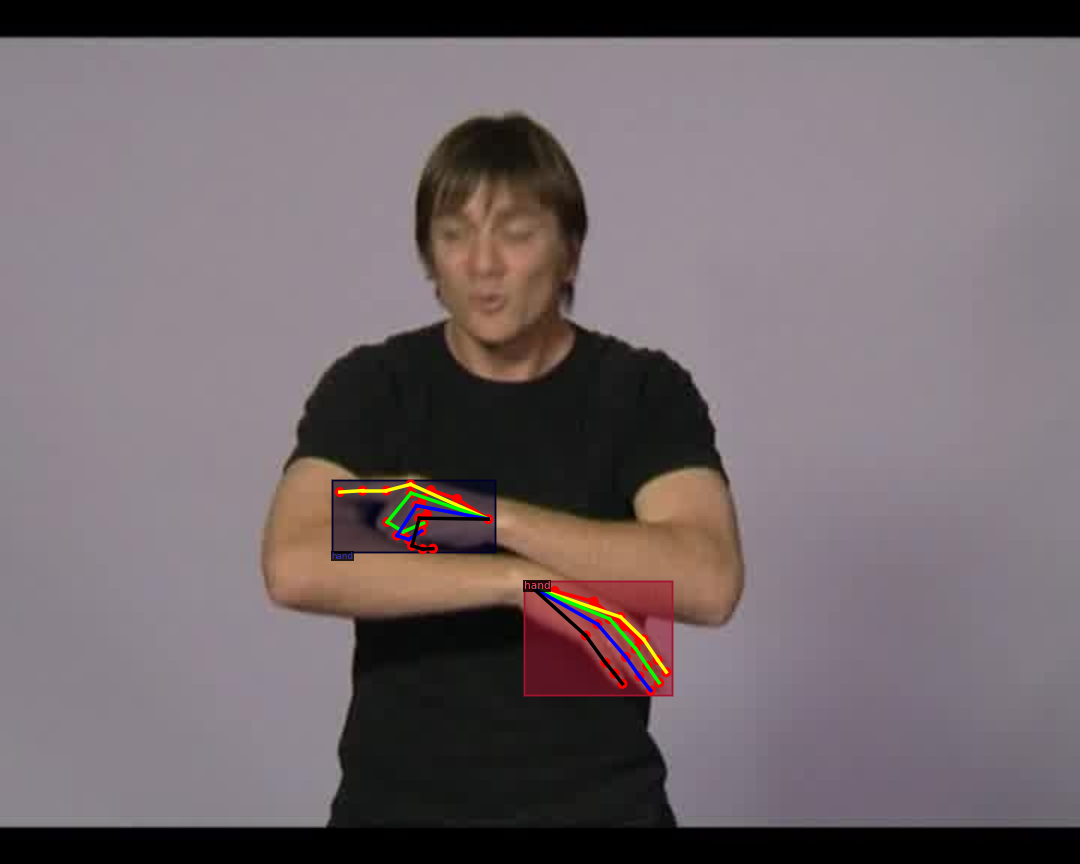

/content/drive/My Drive/NZSL/train_imgs/Alexander_mouse_cat_rooster.flv_000141_.jpg


In [ ]:
from detectron2.utils.visualizer import Visualizer

dataset_dicts = DatasetCatalog.get("nzsl_train")
for d in random.sample(dataset_dicts, 3):
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=train_metadata, scale=1.5)
    vis = visualizer.draw_dataset_dict(d)
    cv2_imshow(vis.get_image()[:, :, ::-1])
    print(d["file_name"])

In [ ]:
val_metadata.keypoint_flip_map=[]
val_metadata.keypoint_names=["0","1","2","3","4","5","6","7","8","9","10","11","12","13","14","15","16","17","18","19","20"]
val_metadata.keypoint_connection_rules=[("0","1",(255,0,0)),("1",'2',(255,0,0)),('2','3',(255,0,0)),('3','4',(255,0,0)),('0','5',(255,255,0)),('5','6',(255,255,0)),('6','7',(255,255,0)),('7','8',(255,255,0)),('0','9',(0,255,0)),('9','10',(0,255,0)),('10','11',(0,255,0)),('11','12',(0,255,0)),('0','13',(0,0,255)),('13','14',(0,0,255)),('14','15',(0,0,255)),('15','16',(0,0,255)),('0','17',(0,0,0)),('17','18',(0,0,0)),('18','19',(0,0,0)),('19','20',(0,0,0))]

In [ ]:
train_metadata.keypoint_names=["0","1","2","3","4","5","6","7","8","9","10","11","12","13","14","15","16","17","18","19","20"]
train_metadata.keypoint_connection_rules=[("0","1",(255,0,0)),("1",'2',(255,0,0)),('2','3',(255,0,0)),('3','4',(255,0,0)),('0','5',(255,255,0)),('5','6',(255,255,0)),('6','7',(255,255,0)),('7','8',(255,255,0)),('0','9',(0,255,0)),('9','10',(0,255,0)),('10','11',(0,255,0)),('11','12',(0,255,0)),('0','13',(0,0,255)),('13','14',(0,0,255)),('14','15',(0,0,255)),('15','16',(0,0,255)),('0','17',(0,0,0)),('17','18',(0,0,0)),('18','19',(0,0,0)),('19','20',(0,0,0))]
train_metadata.keypoint_flip_map=[]

##Training

In [ ]:
cfg = get_cfg()
cfg.merge_from_file("/content/drive/My Drive/KP_RN_Configs/KP_RN_FPN_3x.yaml")
cfg.DATASETS.TRAIN = ("nzsl_train",)
cfg.DATASETS.VAL = ()
cfg.DATASETS.TEST = ()
cfg.DATALOADER.NUM_WORKERS = 2
cfg.SOLVER.IMS_PER_BATCH = 4
cfg.MODEL.DEVICE = "cuda"
cfg.MODEL.WEIGHTS = '/content/drive/My Drive/nzsl_with_rot_59_actual/model_final.pth'
cfg.SOLVER.BASE_LR = 0.0001 
cfg.VIS_PERIOD = 0

cfg.MODEL.ROI_KEYPOINT_HEAD.LOSS_WEIGHT = 1.0
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 2
cfg.MODEL.ROI_HEADS.POSITIVE_FRACTION = 1.0
cfg.MODEL.ANCHOR_GENERATOR.SIZES = [[x, x * 2**(1.0/3), x * 2**(2.0/3) ] for x in [64, 128, 256, 512 ]] 
cfg.SOLVER.MAX_ITER = 14000
cfg.SOLVER.WARMUP_ITERS = 200
cfg.OUTPUT_DIR = "./output"
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg) 
trainer.resume_or_load(resume=False)
trainer.train()

## Visualizing predictions on the test set using the trained model


In [ ]:
cfg.INPUT.MIN_SIZE_TEST = 0
cfg.MODEL.WEIGHTS = '/content/drive/My Drive/KPRetinaNet_L1_loss_14k_xy/model_final.pth'
cfg.MODEL.RETINANET.SCORE_THRESH_TEST = 0.8
cfg.DATASETS.TEST = ("nzsl_test", )
predictor = DefaultPredictor(cfg)

[07/02 13:45:47 d2.data.datasets.coco]: Loaded 231 images in COCO format from /content/drive/My Drive/NZSL/hands_keypoints_test.json
x offsets are tensor([[569.5656],
        [418.7975]], device='cuda:0')
y offsets are tensor([[333.7192],
        [268.7029]], device='cuda:0')
widths are tensor([[85.2850],
        [87.0011]], device='cuda:0')
heights are tensor([[163.2681],
        [194.2081]], device='cuda:0')
tensor([[[600.3485, 486.7165,   1.0000],
         [596.7805, 466.8105,   1.0000],
         [592.3773, 430.6060,   1.0000],
         [603.0558, 400.0829,   1.0000],
         [639.5149, 353.5331,   1.0000],
         [590.5014, 410.9590,   1.0000],
         [622.5931, 373.2394,   1.0000],
         [634.2479, 357.9231,   1.0000],
         [638.6058, 351.9186,   1.0000],
         [600.5166, 417.5574,   1.0000],
         [625.4999, 386.7557,   1.0000],
         [629.7325, 367.1032,   1.0000],
         [630.5363, 359.3553,   1.0000],
         [602.0634, 421.9256,   1.0000],
         [62

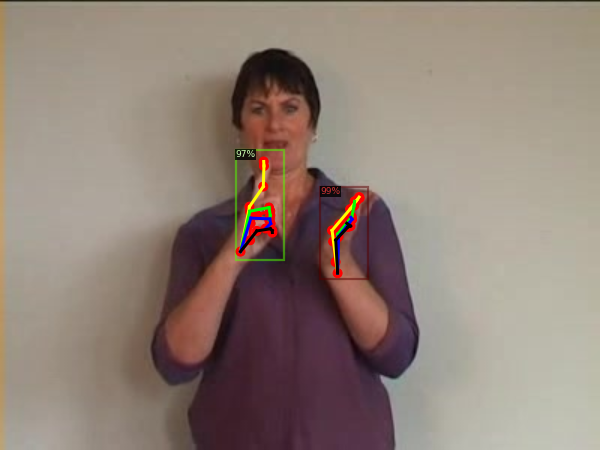

/content/drive/My Drive/NZSL/test_imgs/ex1_2.flv_000010_.jpg
x offsets are tensor([[401.0847],
        [304.7387]], device='cuda:0')
y offsets are tensor([[597.7109],
        [183.6495]], device='cuda:0')
widths are tensor([[132.7380],
        [ 94.8662]], device='cuda:0')
heights are tensor([[81.6188],
        [78.7186]], device='cuda:0')
tensor([[[525.7573, 630.2897,   1.0000],
         [511.9716, 611.4315,   1.0000],
         [485.8587, 607.2362,   1.0000],
         [475.0042, 613.8196,   1.0000],
         [457.1977, 611.9561,   1.0000],
         [482.1062, 637.9979,   1.0000],
         [452.9011, 641.3881,   1.0000],
         [431.8817, 644.8638,   1.0000],
         [420.6368, 648.7020,   1.0000],
         [483.5744, 651.4023,   1.0000],
         [450.2615, 652.5266,   1.0000],
         [423.4562, 652.8948,   1.0000],
         [414.3727, 644.8404,   1.0000],
         [487.2216, 661.4359,   1.0000],
         [456.7151, 659.4399,   1.0000],
         [429.3274, 657.7537,   1.0000],
  

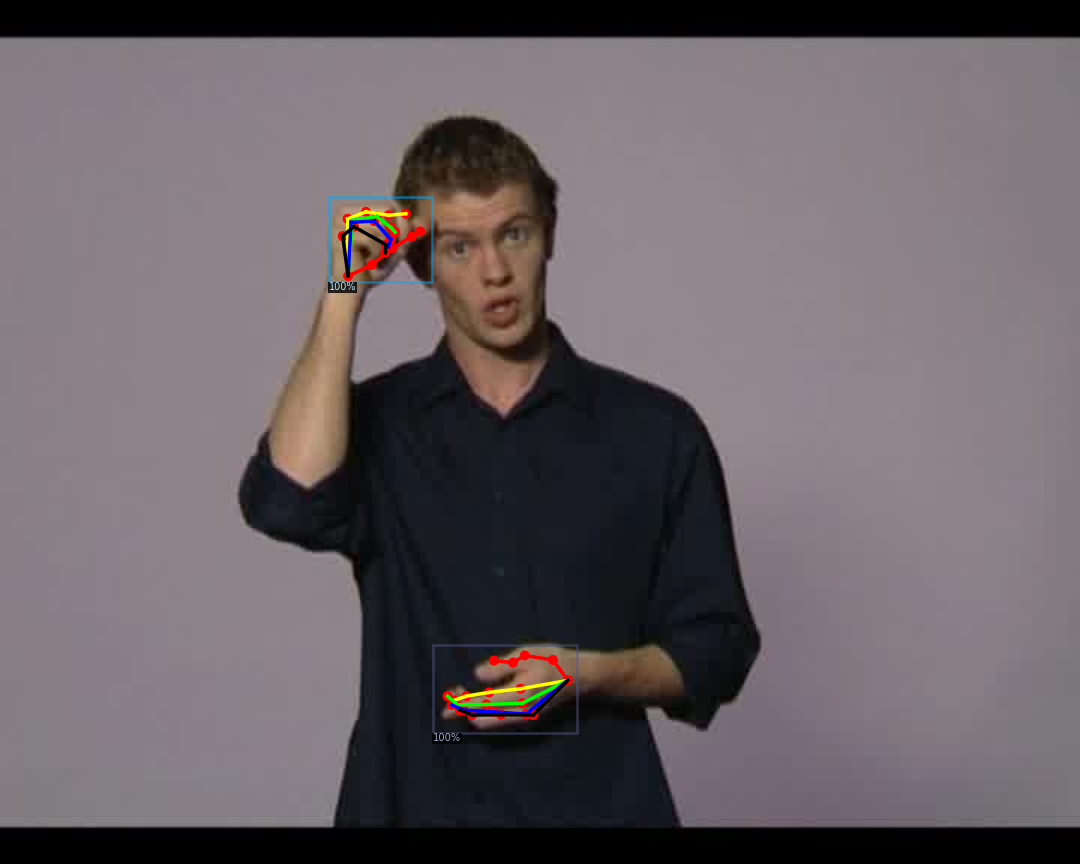

/content/drive/My Drive/NZSL/test_imgs/Berry_sermon_story.flv_000118_.jpg
x offsets are tensor([[469.0795],
        [440.2747]], device='cuda:0')
y offsets are tensor([[674.8295],
        [216.3056]], device='cuda:0')
widths are tensor([[145.6239],
        [103.7531]], device='cuda:0')
heights are tensor([[ 99.2922],
        [213.6069]], device='cuda:0')
tensor([[[604.4871, 688.9948,   1.0000],
         [570.4701, 683.1098,   1.0000],
         [531.9609, 689.2723,   1.0000],
         [508.8890, 715.4441,   1.0000],
         [487.0829, 726.1892,   1.0000],
         [517.8239, 699.6610,   1.0000],
         [490.7590, 726.4293,   1.0000],
         [483.4309, 735.5804,   1.0000],
         [476.8516, 743.1956,   1.0000],
         [535.2997, 712.2308,   1.0000],
         [500.3575, 735.4645,   1.0000],
         [497.4560, 745.2541,   1.0000],
         [495.1749, 751.2599,   1.0000],
         [551.9226, 725.9340,   1.0000],
         [521.6435, 751.9426,   1.0000],
         [523.6456, 754.4041

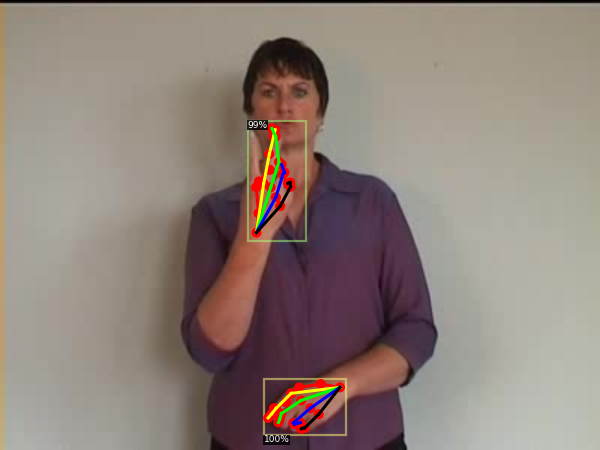

/content/drive/My Drive/NZSL/test_imgs/ex2_2.flv_000060_.jpg


In [ ]:
from detectron2.utils.visualizer import Visualizer

dataset_dicts = DatasetCatalog.get("nzsl_test")
for d in random.sample(dataset_dicts, 3):
    img = cv2.imread(d["file_name"])
    outputs = predictor(img)
    v = Visualizer(img[:, :, ::-1],
                   metadata=val_metadata, 
                   scale=1.5, 
    )
    v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    cv2_imshow(v.get_image()[:, :, ::-1])
    print(d["file_name"])